# 3D Point Triangulation

In this exercise, we will triangulate facial landmarks of multiview face images, using landmarks acquired by Face-Alignment package.

### Import packages

In [1]:
import numpy as np
import torch
import json
import pickle

### Install Face Alignment package

In [2]:
import face_alignment
from skimage import io
import numpy as np

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False)

/home/devrok/.conda/envs/vision_snuenv_pt/lib/python3.10/site-packages/skimage/color/colorconv.py:55: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy import linalg


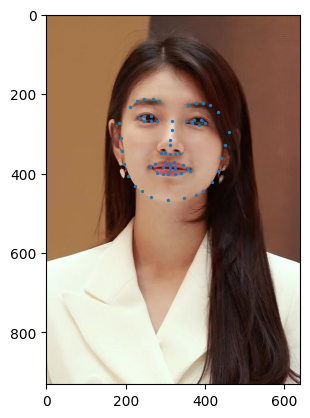

In [3]:
input = io.imread('./img_data/suzy.jpg')
preds = fa.get_landmarks(input)
import matplotlib.pyplot as plt

plt.imshow(input)
for detection in preds:
	plt.scatter(detection[:, 0], detection[:, 1], 2)

In [23]:
# Loading intrinsics and extrinsics
extrinsics = np.load("floored_scaled_transform.npz", allow_pickle=True)
extrinsics = {cam_num : extrinsics[cam_num] for cam_num in extrinsics.files}

with open("undistorted_intrinsics.json", "r") as f:
  intrinsics = json.load(f)

face_cam_indices = ["15", "16", "22", "27", "28", "31", "32"] # 69개의 cam list 중 7개를 뽑음

ext_list = []
int_list = []

for cam_idx in face_cam_indices:
	exts = extrinsics[cam_idx]
	ints = intrinsics[cam_idx]
	w2c = np.linalg.inv(exts)
	w2c = w2c[:3]
	ext_list.append(torch.tensor(w2c).type(torch.float32))
	ints = torch.tensor(ints["Intrinsics"]).reshape((3,3))
	int_list.append(ints)

# Making camera matrix
cam_mat_list = []
for i in range(7):
    cam_mat = int_list[i] @ ext_list[i]
    cam_mat_list.append(cam_mat)

# Loading gt facial landmarks
with open("gt_landmarks.pkl", "rb") as f:
  gt_landmarks = pickle.load(f)

In [24]:
len(extrinsics), len(intrinsics), len(face_cam_indices)
# 69개 카메라의 extrinsics, intrinsics, 선택된 카메라 번호

(69, 69, 7, 7)

In [43]:
len(gt_landmarks), len(gt_landmarks['16']), len(gt_landmarks['16'][0]), len(gt_landmarks['16'][0][0])
# 7 : 선택된 카메라 개수
# 1295 : 수집된 프레임 개수
# 68 : 프레임 당 point 개수
# 2 : 포인트 위치

(7, 1295, 68, 2)

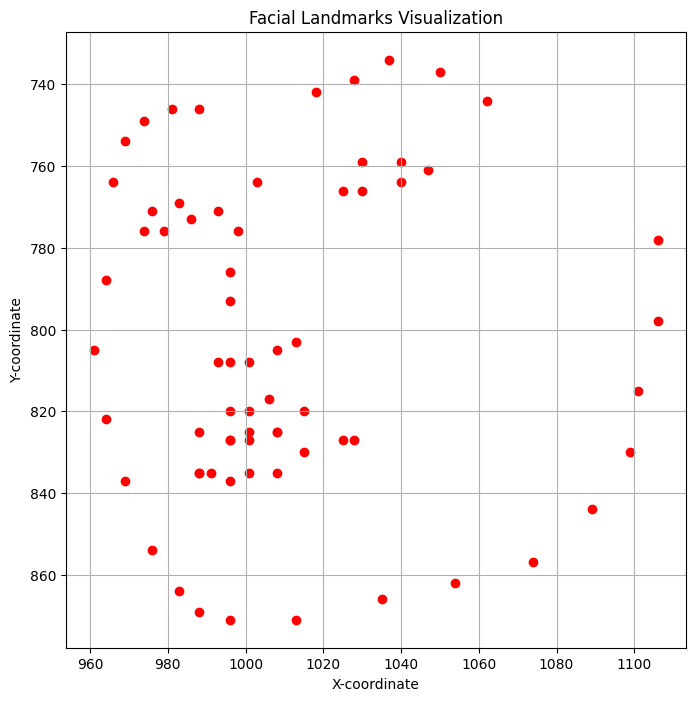

In [44]:
# Landmark visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(gt_landmarks["15"][0, :, 0], gt_landmarks["15"][0, :, 1], c='red', marker='o')
plt.title('Facial Landmarks Visualization')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.gca().invert_yaxis()  # Invert y-axis to match the typical image coordinate system
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


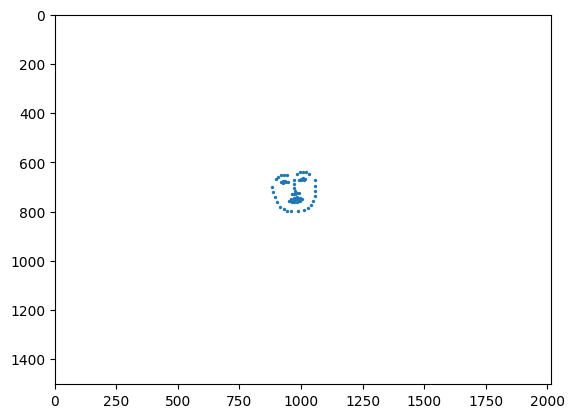

In [45]:
empty_image = np.zeros((1502, 2016, 3))
empty_image = 255 - empty_image
plt.imshow(empty_image)
plt.scatter(gt_landmarks["31"][0, :, 0], gt_landmarks["31"][0, :, 1], 2)

In [48]:
def triangulate(landmarks: np.array, cam_mat: list):
    """
    landmarks : contains pixel coordinates of facial landmarks, 68 X cam_num X 2 array (cma마다 68개의 face 2D point Matrix)
    cam_mat : contains camera parameters of each camera, list of 3x4 matrices of length cam_num
    kp3d : return array of 3d facial landmark keypoints, 68 X 3 array
    """
    num_landmarks = landmarks.shape[0]
    num_cameras = landmarks.shape[1] # same len(cam_mat)
    
    kp3d = np.zeros((num_landmarks, 3))

    for i in range(num_landmarks):
        A = []
        for j in range(num_cameras):
            P = cam_mat[j]
            x, y = landmarks[i, j]
            A.append(x * P[2] - P[0])
            A.append(y * P[2] - P[1])
        A = np.vstack(A)  # Ensure A is a 2D array
        
        # Solve the equation using SVD
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        X = X / X[-1]  # Normalize to make homogeneous coordinate 1
        kp3d[i] = X[:3]
    return kp3d

In [49]:
final_data = np.zeros((1294, 68, 3))
for frame_num in range(1294):
	list1 = []
	for i in range(68):
		list2 = []
		for j in range(7):
			test_point = gt_landmarks[face_cam_indices[j]][frame_num, i]
			list2.append(test_point)
		list1.append(list2)

	data_array = np.array(list1)

	triangulated_point = triangulate(data_array, cam_mat_list)
	final_data[frame_num] = triangulated_point

Animation saved as animation.gif


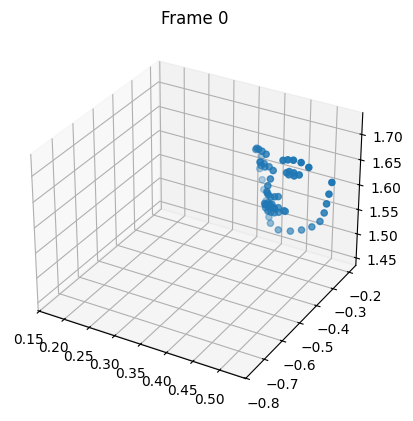

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Example data: Replace this with your actual data
# Assuming data is your numpy array with shape (frame_num, point_num, 3)
plt.rcParams['animation.embed_limit'] = 30 * 1024**2

data = final_data
frame_num, point_num, _ = data.shape

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize the scatter plot
scatter = ax.scatter([], [], [])

# Set the axes limits
ax.set_xlim(np.min(data[:, :, 0]), np.max(data[:, :, 0]))
ax.set_ylim(np.min(data[:, :, 1]), np.max(data[:, :, 1]))
ax.set_zlim(np.min(data[:, :, 2]), np.max(data[:, :, 2]))

# Animation function
def update(frame):
    ax.clear()
    ax.set_xlim(np.min(data[:, :, 0]), np.max(data[:, :, 0]))
    ax.set_ylim(np.min(data[:, :, 1]), np.max(data[:, :, 1]))
    ax.set_zlim(np.min(data[:, :, 2]), np.max(data[:, :, 2]))
    ax.scatter(data[frame, :, 0], data[frame, :, 1], data[frame, :, 2])
    ax.set_title(f'Frame {frame}')

# Create an animation
ani = FuncAnimation(fig, update, frames=frame_num, interval=60)

# Display the animation
#HTML(ani.to_jshtml())

# Save the animation as a GIF file using Pillow
ani.save('animation.gif', writer='pillow', fps=10)
print("Animation saved as animation.gif")